In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## **Reading the data**

In [2]:
# Load the dataset
url = '/kaggle/input/ecommerce/E-commerce_data.xlsx'
data = pd.read_excel(url, sheet_name=None)

# Read the tables
customers = data['customers']
genders = data['genders']
cities = data['cities']
transactions = data['transactions']
branches = data['branches']
merchants = data['merchants']

## **Merging the dataframes**

In [3]:
# Merge customers with genders and cities
df = pd.merge(customers, genders, on='gender_id')
df = pd.merge(df, cities, on='city_id')

In [4]:
# Merge transactions with customers
df = pd.merge(df, transactions, on='customer_id')

# Merge with branches and merchants
df = pd.merge(df, branches, on='branch_id')
df = pd.merge(df, merchants, on='merchant_id')

In [5]:
df.head(5)

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,2022-01-08,7,1,Male,Mansoura,178,2022-07-30,subscribed,SrP-866,NaT,8,20,Griffin-Leblanc
1,1,2022-01-08,7,1,Male,Mansoura,257,2022-09-19,burned,krI-075,2022-11-05,1,11,"Smith, Lawson and Hernandez"
2,1,2022-01-08,7,1,Male,Mansoura,1652,2022-06-09,burned,quk-137,2022-07-19,6,15,Butler-Gomez
3,1,2022-01-08,7,1,Male,Mansoura,1929,2022-07-30,burned,QiG-754,2022-10-18,8,20,Griffin-Leblanc
4,1,2022-01-08,7,1,Male,Mansoura,2352,2023-03-24,subscribed,OtC-985,NaT,4,15,Butler-Gomez


In [6]:
df.shape

(5000, 14)

In [7]:
# Encode categorical data (Gender, City, Coupon)
label_encoders = {}
for column in ['gender_name', 'city_name', 'transaction_status', 'coupon_name', 'merchant_name']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [8]:
df.head(5)

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,2022-01-08,7,1,1,11,178,2022-07-30,1,1800,NaT,8,20,3
1,1,2022-01-08,7,1,1,11,257,2022-09-19,0,3531,2022-11-05,1,11,6
2,1,2022-01-08,7,1,1,11,1652,2022-06-09,0,4132,2022-07-19,6,15,1
3,1,2022-01-08,7,1,1,11,1929,2022-07-30,0,1596,2022-10-18,8,20,3
4,1,2022-01-08,7,1,1,11,2352,2023-03-24,1,1419,NaT,4,15,1


In [9]:
# Adding frequency of transactions per customer
transaction_frequency = df.groupby('customer_id')['transaction_id'].count().reset_index()
transaction_frequency.columns = ['customer_id', 'transaction_count']
df = pd.merge(df, transaction_frequency, on='customer_id')

In [10]:
df.head(10)

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name,transaction_count
0,1,2022-01-08,7,1,1,11,178,2022-07-30,1,1800,NaT,8,20,3,7
1,1,2022-01-08,7,1,1,11,257,2022-09-19,0,3531,2022-11-05,1,11,6,7
2,1,2022-01-08,7,1,1,11,1652,2022-06-09,0,4132,2022-07-19,6,15,1,7
3,1,2022-01-08,7,1,1,11,1929,2022-07-30,0,1596,2022-10-18,8,20,3,7
4,1,2022-01-08,7,1,1,11,2352,2023-03-24,1,1419,NaT,4,15,1,7
5,1,2022-01-08,7,1,1,11,3176,2022-02-14,1,3824,NaT,2,18,4,7
6,1,2022-01-08,7,1,1,11,4574,2024-05-26,1,7,NaT,7,7,0,7
7,2,2023-05-02,20,2,0,16,89,2023-10-21,1,1755,NaT,4,15,1,3
8,2,2023-05-02,20,2,0,16,400,2023-05-21,0,4071,2023-05-25,10,13,7,3
9,2,2023-05-02,20,2,0,16,4532,2023-08-04,1,3976,NaT,3,8,5,3


## **Feature Selection**

In [11]:
# Select features for clustering
features = ['gender_name', 'city_name', 'transaction_status', 'coupon_name', 'merchant_name', 'transaction_count']

In [12]:
df.head(10)

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name,transaction_count
0,1,2022-01-08,7,1,1,11,178,2022-07-30,1,1800,NaT,8,20,3,7
1,1,2022-01-08,7,1,1,11,257,2022-09-19,0,3531,2022-11-05,1,11,6,7
2,1,2022-01-08,7,1,1,11,1652,2022-06-09,0,4132,2022-07-19,6,15,1,7
3,1,2022-01-08,7,1,1,11,1929,2022-07-30,0,1596,2022-10-18,8,20,3,7
4,1,2022-01-08,7,1,1,11,2352,2023-03-24,1,1419,NaT,4,15,1,7
5,1,2022-01-08,7,1,1,11,3176,2022-02-14,1,3824,NaT,2,18,4,7
6,1,2022-01-08,7,1,1,11,4574,2024-05-26,1,7,NaT,7,7,0,7
7,2,2023-05-02,20,2,0,16,89,2023-10-21,1,1755,NaT,4,15,1,3
8,2,2023-05-02,20,2,0,16,400,2023-05-21,0,4071,2023-05-25,10,13,7,3
9,2,2023-05-02,20,2,0,16,4532,2023-08-04,1,3976,NaT,3,8,5,3


In [13]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

## **Apply K-Means Clustering**

In [14]:
# Apply K-Means Clustering
inertia = []
silhouette_scores = []
K = range(2, 10)  # Testing with different numbers of clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

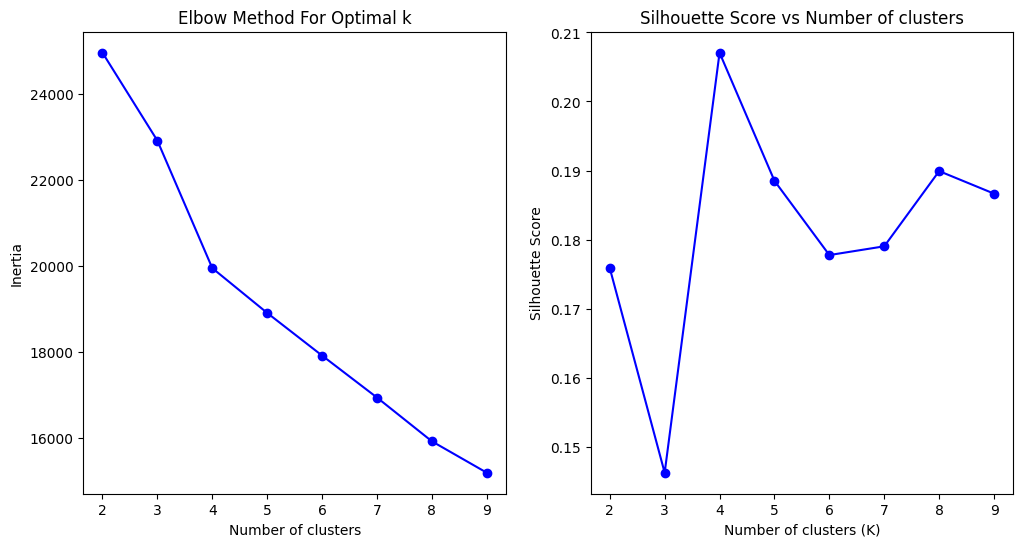

In [15]:
# Plotting Inertia and Silhouette scores to evaluate the best K
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of clusters')
plt.show()

### **Optimal K=4 based on the plots**

In [17]:
# Optimal K=4 based on the plots
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## **Analyze segments**

In [18]:
# Analyze segments
cluster_summary = df.groupby('cluster').agg({
    'transaction_count': 'mean',
    'gender_name': 'mean',
    'city_name': 'mean',
    'transaction_status': 'mean',
    'coupon_name': 'mean',
    'merchant_name': 'mean'
}).reset_index()

print(cluster_summary)

   cluster  transaction_count  gender_name  city_name  transaction_status  \
0        0           6.155642          1.0   9.824903                 0.0   
1        1           5.918765          0.0   8.845654                 0.0   
2        2           5.992512          0.0   8.986689                 1.0   
3        3           6.230109          1.0   9.616225                 1.0   

   coupon_name  merchant_name  
0  2447.248249       3.621012  
1  2527.220146       3.740861  
2  2544.978369       3.696339  
3  2482.616225       3.490640  
